In [34]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix

In [2]:
data=pd.read_csv('/content/Mock_data.csv')

In [14]:
data.head()

,User _ID,Product_ID,Product_Category,Purchase History,Rating
0,U0001,P015,Toys,"[('P015', datetime.date(2024, 9, 16)), ('P022'...",2.7
1,U0001,P022,Groceries,"[('P015', datetime.date(2024, 9, 16)), ('P022'...",3.3
2,U0001,P035,Electronics,"[('P015', datetime.date(2024, 9, 16)), ('P022'...",3.8
3,U0001,P049,Electronics,"[('P015', datetime.date(2024, 9, 16)), ('P022'...",2.2
4,U0002,P010,Electronics,"[('P010', datetime.date(2024, 6, 17)), ('P030'...",1.5


<ipython-input-13-995b29ff6342>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='Rating', y='Product_Category', inner='stick', palette='Dark2')


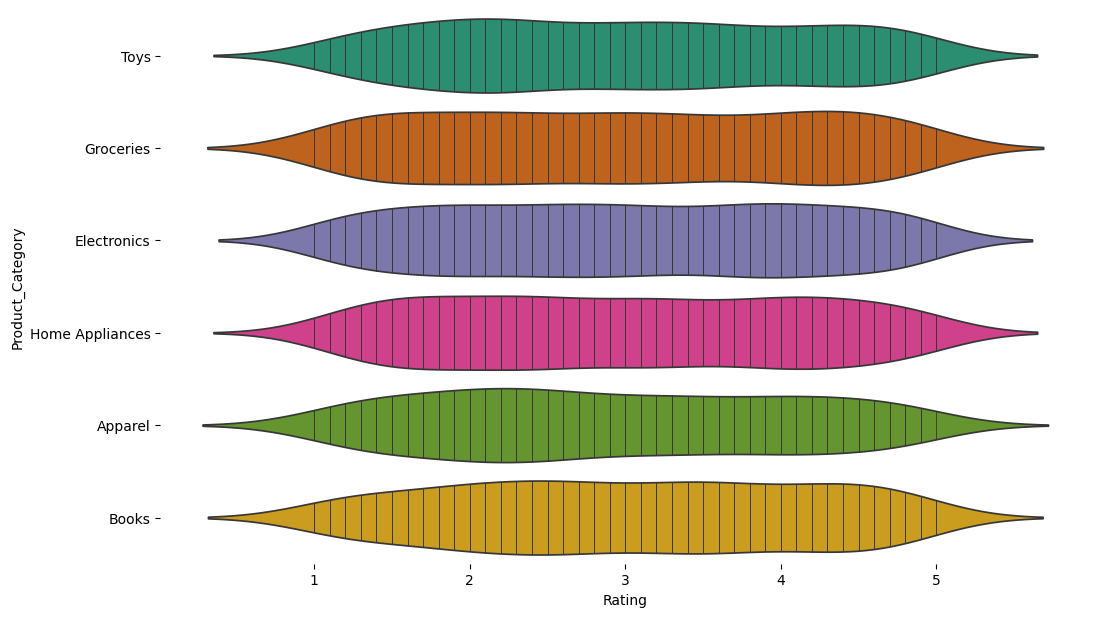

In [13]:
figsize = (12, 1.2 * len(data['Product_Category'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='Rating', y='Product_Category', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

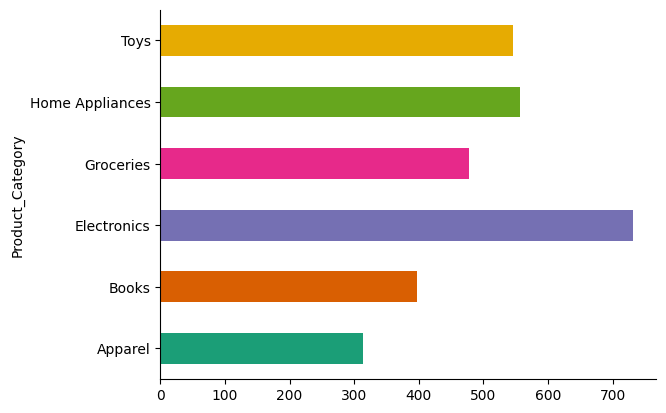

In [11]:
data.groupby('Product_Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

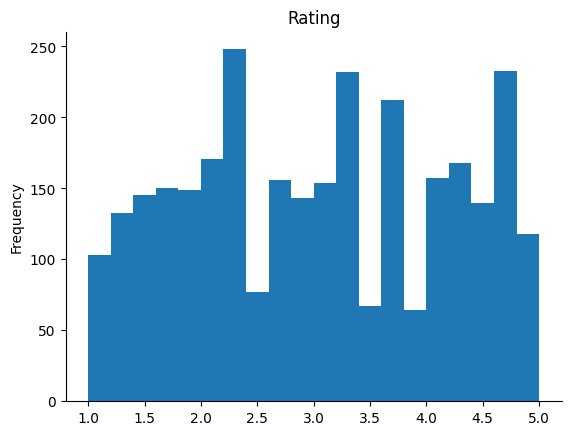

In [9]:
from matplotlib import pyplot as plt
data['Rating'].plot(kind='hist', bins=20, title='Rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   User _ID          3020 non-null   object 
 1   Product_ID        3020 non-null   object 
 2   Product_Category  3020 non-null   object 
 3   Purchase History  3020 non-null   object 
 4   Rating            3020 non-null   float64
dtypes: float64(1), object(4)
memory usage: 118.1+ KB


In [19]:
data.columns

Index(['User _ID', 'Product_ID', 'Product_Category', 'Purchase History',
       'Rating'],
      dtype='object')

In [25]:
#Collaboraticve Filtering using cosine similarity
user_matrix = data.pivot_table(index='User _ID', columns='Product_ID', values='Rating').fillna(0)
user_similarity = cosine_similarity(user_matrix)
def get_recommendations_cs(user_id, top_n=5):
    user_index = np.where(user_matrix.index == user_id)[0][0]
    similar_users = np.argsort(user_similarity[user_index])[::-1][1:] #Exclude the user itself
    r = []

    for i in similar_users:
        similar_user = user_matrix.index[i]
        products_rated_by_similar_user = data[data['User _ID'] == similar_user]
        for _, row in products_rated_by_similar_user.iterrows():
            product_id = row['Product_ID']
            if product_id not in data[data['User _ID'] == user_id]['Product_ID'].values: #Only recommend unrated products
              r.append((product_id, row['Rating']))

    r = sorted(r, key=lambda x: x[1], reverse=True)  #Sort by rating
    return r[:top_n]

recommendations = get_recommendations_cs('U0001')
print(f"Recommendations for U0001: {recommendations}")

Recommendations for U0001: [('P019', 5.0), ('P016', 5.0), ('P024', 5.0), ('P036', 5.0), ('P010', 5.0)]


In [28]:
#Collaboraticve Filtering using neural networks 
user_item_matrix = data.pivot_table(index='User _ID', columns='Product_ID', values='Rating').fillna(0)
user_item_matrix_np = user_item_matrix.values
train_data, test_data = train_test_split(user_item_matrix_np, test_size=0.2, random_state=42)
train_mean = np.mean(train_data)
train_std = np.std(train_data)
train_data_normalized = (train_data - train_mean) / train_std
test_data_normalized = (test_data - train_mean) / train_std

In [30]:
model = keras.Sequential([
    keras.layers.Input(shape=(user_item_matrix.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(user_item_matrix.shape[1])
])
model.compile(optimizer='adam', loss='mse')
model.fit(train_data_normalized, train_data_normalized, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1169 - val_loss: 0.9443
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9508 - val_loss: 0.8736
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8535 - val_loss: 0.7824
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7394 - val_loss: 0.6770
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6298 - val_loss: 0.5841
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5123 - val_loss: 0.5027
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4310 - val_loss: 0.4412
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3435 - val_loss: 0.3868
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3004 - val_loss: 0.3417
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2510 - val_loss: 0.2993


In [32]:
predictions_normalized = model.predict(test_data_normalized)
predictions = predictions_normalized * train_std + train_mean
def get_recommendations_nn(user_id, top_n=5):
    user_index = np.where(user_item_matrix.index == user_id)[0][0]
    predictions_for_user = predictions[user_index]

    top_indices = np.argsort(predictions_for_user)[::-1][:top_n]
    recommendations = [(user_item_matrix.columns[i], predictions_for_user[i]) for i in top_indices]

    return recommendations

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [33]:
nn_recommendations = get_recommendations_nn('U0001')
cosine_recommendations = get_recommendations_cs('U0001')

print(f"Neural Network Recommendations for U0001: {nn_recommendations}")
print(f"Cosine Similarity Recommendations for U0001: {cosine_recommendations}")

Neural Network Recommendations for U0001: [('P029', 3.3038511), ('P048', 2.1507916), ('P035', 1.9050499), ('P012', 0.9180042), ('P049', 0.8766066)]
Cosine Similarity Recommendations for U0001: [('P019', 5.0), ('P016', 5.0), ('P024', 5.0), ('P036', 5.0), ('P010', 5.0)]
